In [1]:
import pandas as pd
import numpy as np
import lasio
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import keras_tuner
from kerastuner.tuners import RandomSearch

C:\Users\Reda\AppData\Local\Temp\ipykernel_10964\623304695.py:22: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
input1 = lasio.read(r'Volve/15_9-F-1_INPUT_1.LAS').df()[['GR','NPHI','RHOB']]
input2 = lasio.read(r'Volve/15_9-F-1A_INPUT_1.LAS').df()[['GR','NPHI','RHOB']]
input3 = lasio.read(r'Volve/15_9-F-1B_INPUT_1.LAS').df()[['GR','NPHI','RHOB']]
input4 = lasio.read(r'Volve/15_9-F-1C_INPUT_1.LAS').df()[['GR','NPHI','RHOB']]
input5 = lasio.read(r'Volve/15_9-F-12_INPUT_1.LAS').df()[['GR','NPHI','RHOB']]

In [3]:
output1 = lasio.read(r'Volve/15_9-F-1_OUTPUT_1.LAS').df()['KLOGH']
output2 = lasio.read(r'Volve/15_9-F-1A_OUTPUT_1.LAS').df()['KLOGH']
output3 = lasio.read(r'Volve/15_9-F-1B_OUTPUT_1.LAS').df()['KLOGH']
output4 = lasio.read(r'Volve/15_9-F-1C_OUTPUT_1.LAS').df()['KLOGH']
output5 = lasio.read(r'Volve/15_9-F-12_OUTPUT_1.LAS').df()['KLOGH']

In [4]:
well1 =pd.merge(input1,output1,on='DEPTH')
well2 = pd.merge(input2,output2,on='DEPTH')
well3 = pd.merge(input3,output3,on='DEPTH')
well4 = pd.merge(input4,output4,on='DEPTH')
well5 = pd.merge(input5,output5,on='DEPTH')

wells=[well1,well2,well3,well4,well5]
data=pd.concat(wells,ignore_index=False,join='outer')

In [5]:
data = data.dropna()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18324 entries, 3319.7 to 3505.3524
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GR      18324 non-null  float64
 1   NPHI    18324 non-null  float64
 2   RHOB    18324 non-null  float64
 3   KLOGH   18324 non-null  float64
dtypes: float64(4)
memory usage: 715.8 KB


In [7]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Remove outliers
columns_to_check = data.columns
df_cleaned = remove_outliers(data, columns_to_check)

# Normalize the data using Min-Max Scaling
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)


df_scaled.head()

,GR,NPHI,RHOB,KLOGH
0,0.882841,0.205298,0.688603,0.000000
1,0.650177,0.204129,0.681742,0.000005
2,0.499854,0.202571,0.654159,0.000212
3,0.441871,0.208025,0.611033,0.000889
4,0.403819,0.199455,0.561187,0.002645


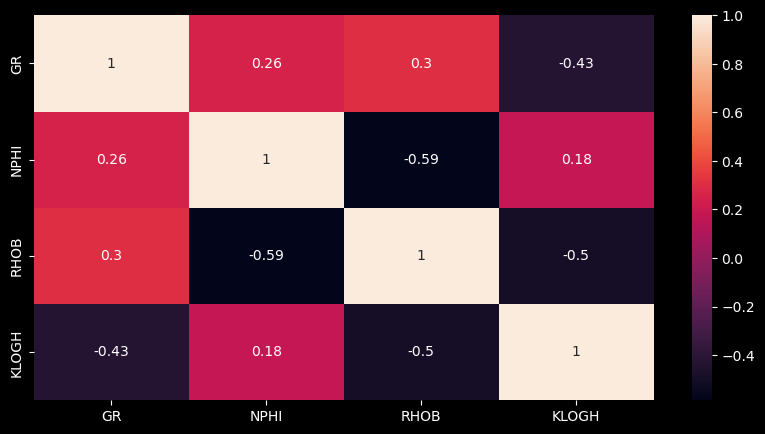

In [32]:
plt.figure(figsize=(10,5))
sns.heatmap(df_scaled.corr(), annot=True)
plt.show()

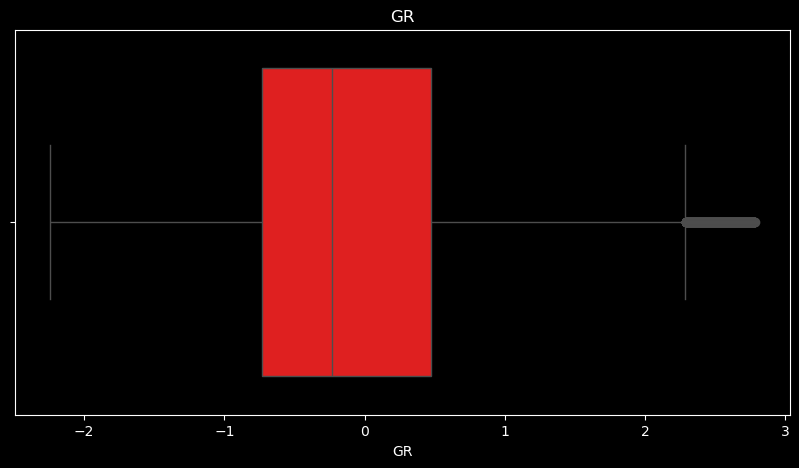

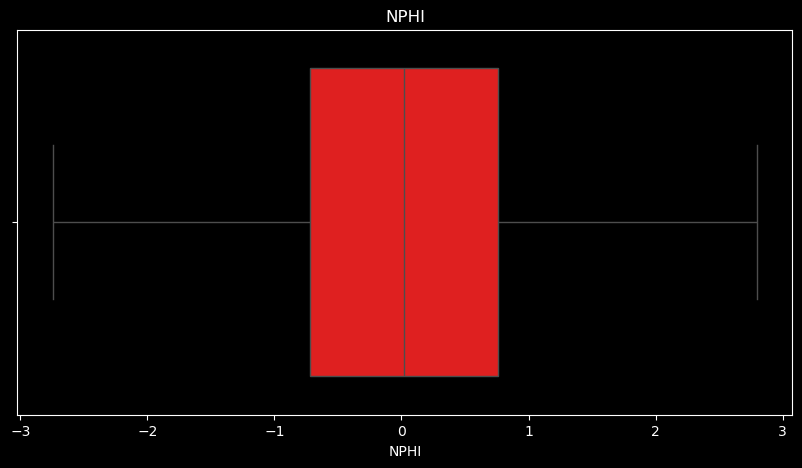

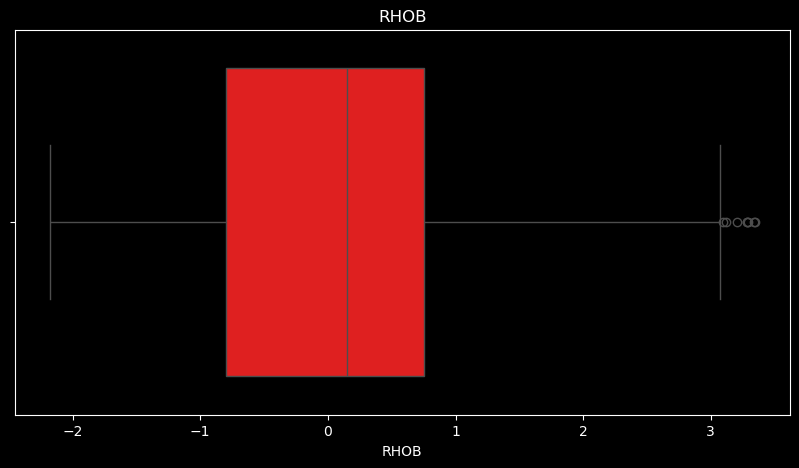

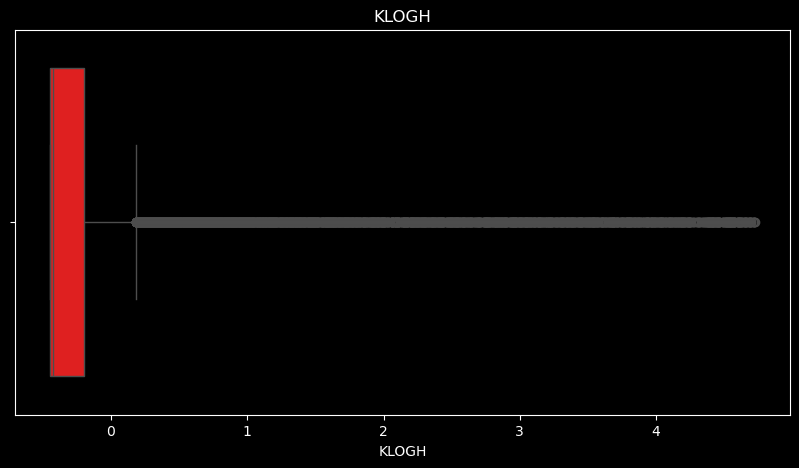

In [33]:
for i in df_scaled.columns:
    plt.figure(figsize=(10,5))
    sns.boxplot(x=df_scaled[i],color = 'red')
    plt.title(i)

In [10]:
X = df_scaled.iloc[:,:3]
y = df_scaled['KLOGH']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'Neural Network': MLPRegressor(random_state=42, max_iter=1000)
}

results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results[model_name] = {'MAE': mae, 'MSE': mse, 'Predictions': y_pred}


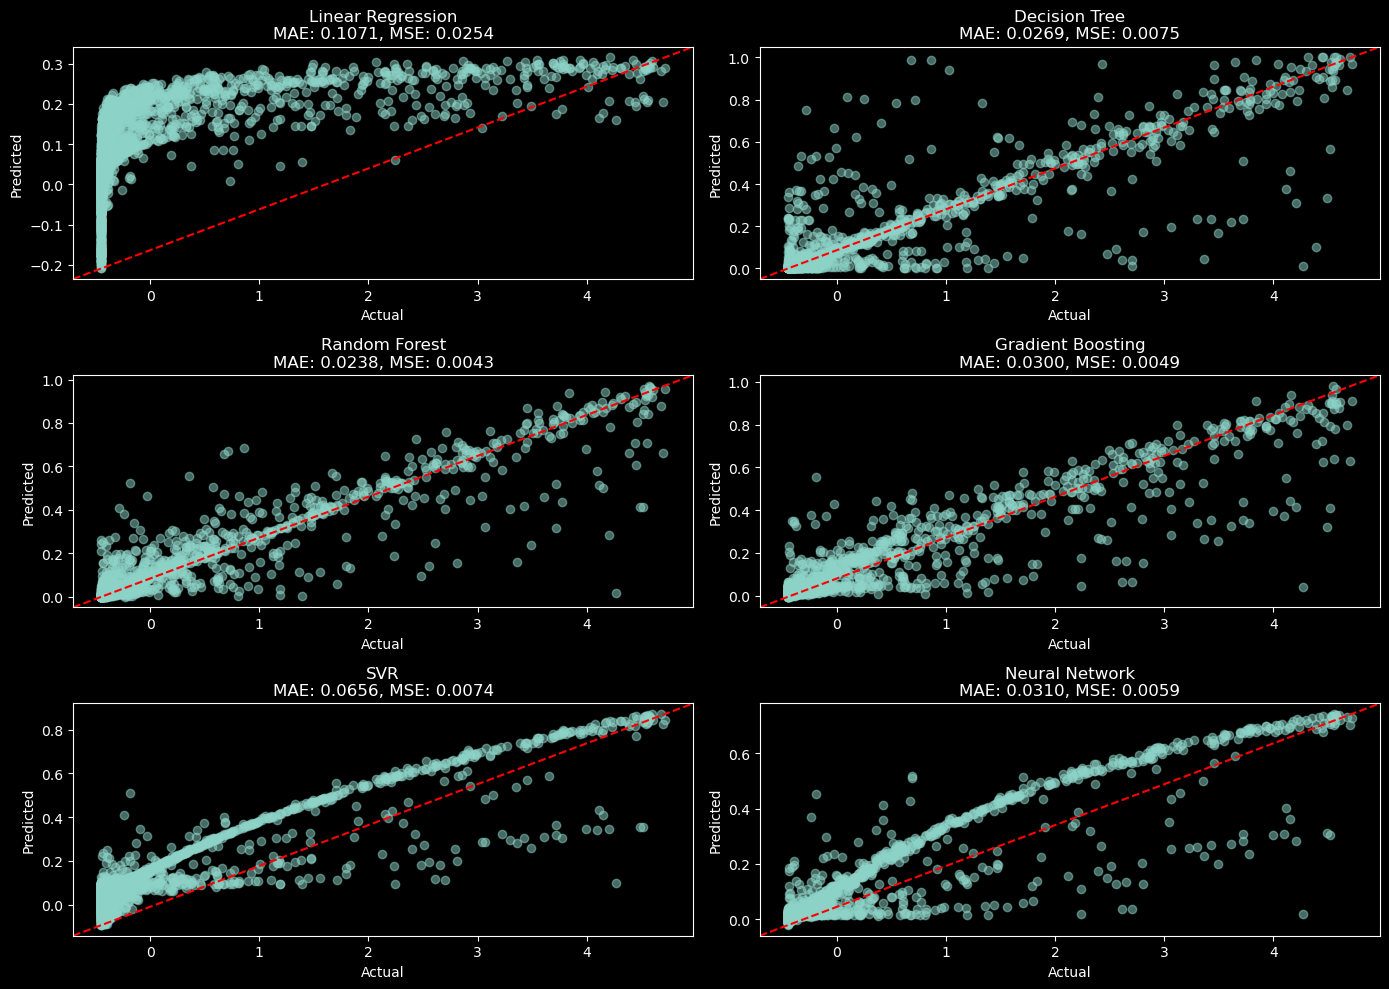

In [31]:
plt.figure(figsize=(14, 10))
for i, (model_name, result) in enumerate(results.items(), 1):
    plt.subplot(3, 2, i)
    plt.scatter(y_test, result['Predictions'], alpha=0.5)
    plt.plot([0, 1], [0, 1], '--', color='red', transform=plt.gca().transAxes)
    plt.title(f'{model_name}\nMAE: {result["MAE"]:.4f}, MSE: {result["MSE"]:.4f}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.tight_layout()

plt.show()


In [13]:
# Normalize the data using Standard Scaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)

# Separate features and target variable
features = ['GR','NPHI','RHOB']
X = df_scaled[features]
y = df_scaled['KLOGH']


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

C:\Users\Reda\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [17]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32, verbose=0)

In [18]:
loss, mae = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1107 - mean_absolute_error: 0.1336
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [19]:
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {loss}')
print(f'R2 Score: {r2}')

Mean Absolute Error: 0.1362006515264511
Mean Squared Error: 0.123834528028965
R2 Score: 0.8803958873970946


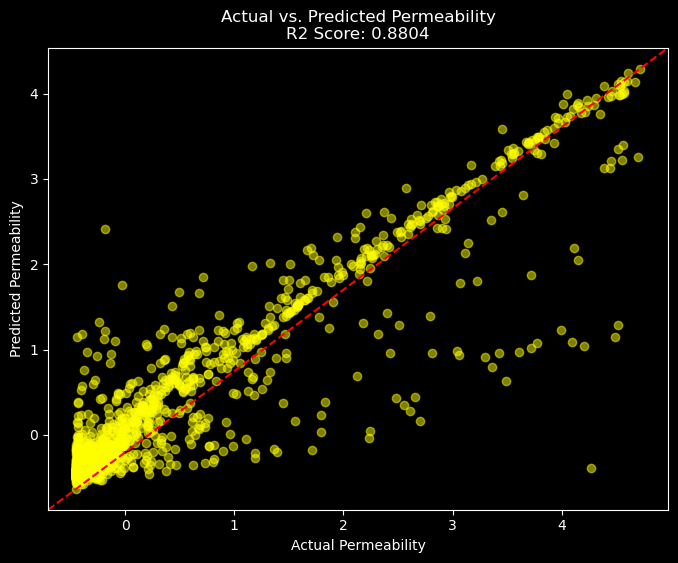

In [20]:
plt.style.use('dark_background')
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='yellow')
plt.plot([0, 1], [0, 1], '--', color='red', transform=plt.gca().transAxes)
plt.title(f'Actual vs. Predicted Permeability\nR2 Score: {r2:.4f}')
plt.xlabel('Actual Permeability')
plt.ylabel('Predicted Permeability')
plt.show()

## ANN Model

In [21]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu', input_dim=X_train.shape[1]))
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), 
                  loss='mean_squared_error', 
                  metrics=['mean_absolute_error'])
    return model

In [22]:
tuner = RandomSearch(
    build_model,
    objective='val_mean_absolute_error',
    max_trials=20,
    executions_per_trial=3,
    directory='my_dir',
    project_name='permeability_tuning2'
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

Reloading Tuner from my_dir\permeability_tuning2\tuner0.json


In [23]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal number of units in the first densely-connected layer is {best_hps.get('units')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Train the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32, verbose=1)


The optimal number of units in the first densely-connected layer is 128.
The optimal learning rate for the optimizer is 0.001.



C:\Users\Reda\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.3801 - mean_absolute_error: 0.3309 - val_loss: 0.2125 - val_mean_absolute_error: 0.1764
Epoch 2/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.1799 - mean_absolute_error: 0.1855 - val_loss: 0.2055 - val_mean_absolute_error: 0.2093
Epoch 3/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.1722 - mean_absolute_error: 0.1792 - val_loss: 0.1879 - val_mean_absolute_error: 0.1682
Epoch 4/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1580 - mean_absolute_error: 0.1616 - val_loss: 0.1901 - val_mean_absolute_error: 0.1743
Epoch 5/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.1620 - mean_absolute_error: 0.1671 - val_loss: 0.1837 - val_mean_absolute_error: 0.1594
Epoch 6/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.1600 - mean_absolute_error: 0.1625 - val_loss: 0.2180 - val_mean_absolute_error: 0.1847
Epoch 7/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.1457 - mean_absolute_er

In [24]:
# Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Mean Absolute Error: 0.13765597377661357
Mean Squared Error: 0.13991181079123954
R2 Score: 0.8648678104053007


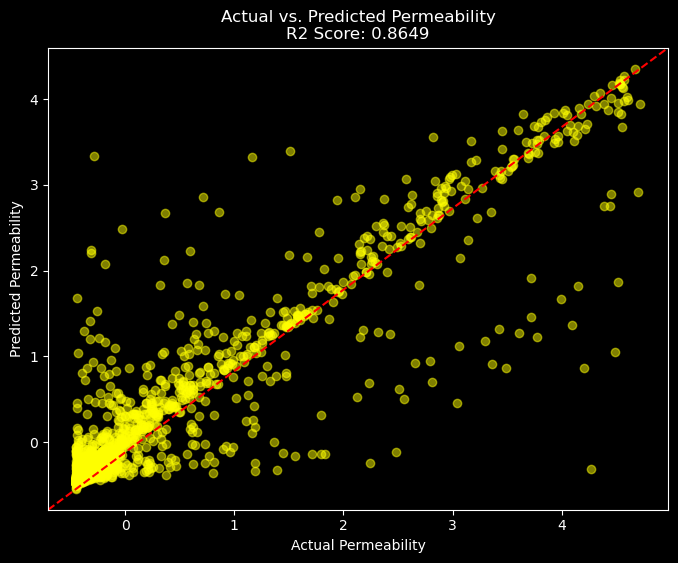

In [25]:
# Plot actual vs. predicted values 
plt.style.use('dark_background')
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='yellow')
plt.plot([0, 1], [0, 1], '--', color='red', transform=plt.gca().transAxes)
plt.title(f'Actual vs. Predicted Permeability\nR2 Score: {r2:.4f}')
plt.xlabel('Actual Permeability')
plt.ylabel('Predicted Permeability')
plt.show()

In [26]:
# data.to_csv('Combined_logs.csv')

In [27]:
tuner = RandomSearch(
    build_model,
    objective='val_mean_absolute_error',
    max_trials=20,
    executions_per_trial=3,
    directory='my_dir',
    project_name='permeability_tuning'
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

Reloading Tuner from my_dir\permeability_tuning\tuner0.json


In [28]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal number of units in the first densely-connected layer is {best_hps.get('units')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Train the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32, verbose=1)


The optimal number of units in the first densely-connected layer is 96.
The optimal learning rate for the optimizer is 0.001.



C:\Users\Reda\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 0.3880 - mean_absolute_error: 0.3315 - val_loss: 0.2376 - val_mean_absolute_error: 0.2409
Epoch 2/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.1886 - mean_absolute_error: 0.1910 - val_loss: 0.2224 - val_mean_absolute_error: 0.1898
Epoch 3/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 0.1578 - mean_absolute_error: 0.1743 - val_loss: 0.2002 - val_mean_absolute_error: 0.1845
Epoch 4/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.1799 - mean_absolute_error: 0.1758 - val_loss: 0.1837 - val_mean_absolute_error: 0.1512
Epoch 5/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.1590 - mean_absolute_error: 0.1590 - val_loss: 0.1944 - val_mean_absolute_error: 0.1788
Epoch 6/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.1734 - mean_absolute_error: 0.1705 - val_loss: 0.1777 - val_mean_absolute_error: 0.1719
Epoch 7/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.1502 - mean_absolute_

In [29]:
# Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Mean Absolute Error: 0.12372613521065175
Mean Squared Error: 0.12109735958807626
R2 Score: 0.883039528523506


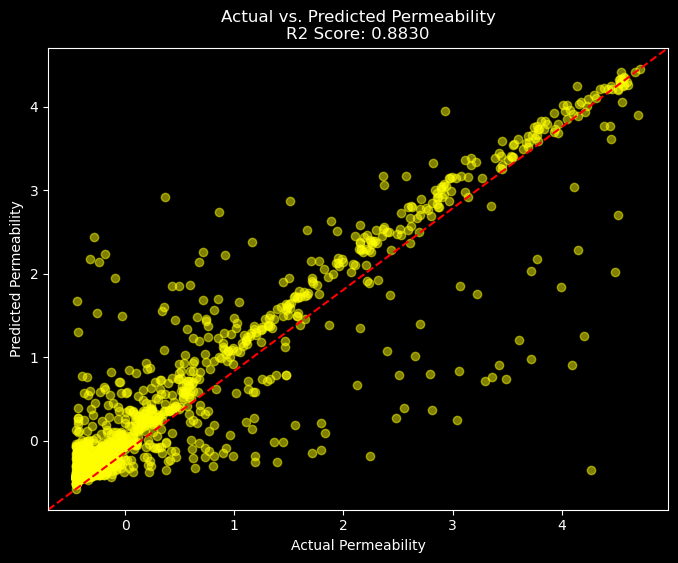

In [30]:
# Plot actual vs. predicted values 
plt.style.use('dark_background')
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='yellow')
plt.plot([0, 1], [0, 1], '--', color='red', transform=plt.gca().transAxes)
plt.title(f'Actual vs. Predicted Permeability\nR2 Score: {r2:.4f}')
plt.xlabel('Actual Permeability')
plt.ylabel('Predicted Permeability')
plt.show()